In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("MovieRatings").getOrCreate()

In [0]:
# Read Data using Spark

ratings = spark.read.csv("dbfs:/FileStore/rating.csv", header=True, inferSchema=True) # catalog - copy path - spark api format
# Data Exploration
ratings.show(5)


+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|     1|      2|   3.5|2005-04-02 23:53:47|
|     1|     29|   3.5|2005-04-02 23:31:16|
|     1|     32|   3.5|2005-04-02 23:33:39|
|     1|     47|   3.5|2005-04-02 23:32:07|
|     1|     50|   3.5|2005-04-02 23:29:40|
+------+-------+------+-------------------+
only showing top 5 rows



In [0]:
# Read Data using Spark
movies = spark.read.csv("dbfs:/FileStore/movie.csv", header=True, inferSchema=True)
# Data Exploration
movies.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
# Join DataFrames
movie_ratings = ratings.join(movies, on="movieId", how="inner")
movie_ratings.select("title", "rating").show(5)

+--------------------+------+
|               title|rating|
+--------------------+------+
|      Jumanji (1995)|   3.5|
|City of Lost Chil...|   3.5|
|Twelve Monkeys (a...|   3.5|
|Seven (a.k.a. Se7...|   3.5|
|Usual Suspects, T...|   3.5|
+--------------------+------+
only showing top 5 rows



In [0]:
# Compute Average Ratings
avg_ratings = movie_ratings.groupBy("title").avg("rating").orderBy("avg(rating)", ascending=False)
avg_ratings.show(10)

+--------------------+-----------+
|               title|avg(rating)|
+--------------------+-----------+
|Always for Pleasu...|        5.0|
|Neurons to Nirvan...|        5.0|
|  Catastroika (2012)|        5.0|
|Latin Music USA (...|        5.0|
|       B-Side (2013)|        5.0|
|   Rent-a-Cat (2012)|        5.0|
|This Thing With S...|        5.0|
|Doggiewoggiez! Po...|        5.0|
|The Color of Milk...|        5.0|
|The Sea That Thin...|        5.0|
+--------------------+-----------+
only showing top 10 rows



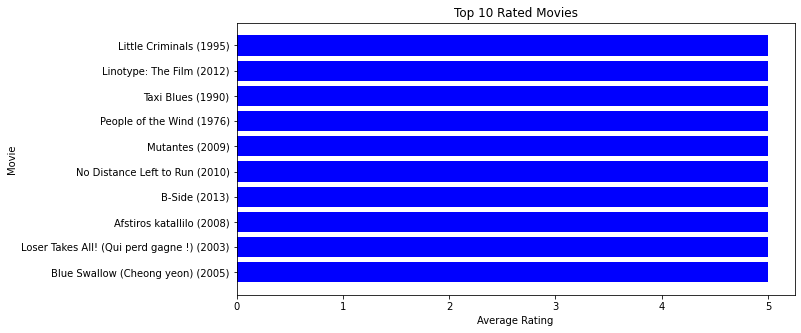

In [0]:
# Visualization using Databricks Display
import matplotlib.pyplot as plt

top_movies = avg_ratings.limit(10).toPandas()
plt.figure(figsize=(10,5))
plt.barh(top_movies['title'], top_movies['avg(rating)'], color='blue')
plt.xlabel("Average Rating")
plt.ylabel("Movie")
plt.title("Top 10 Rated Movies")
plt.show()

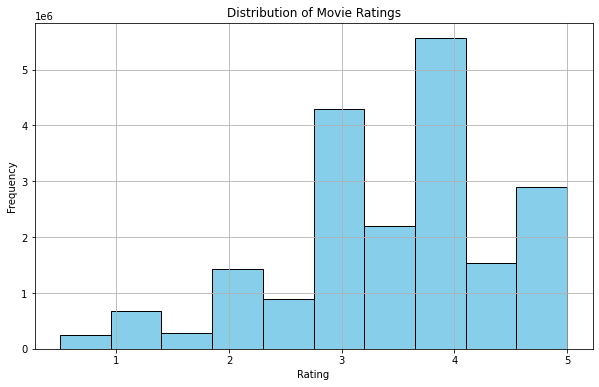

In [0]:
# Distribution of Ratings
import matplotlib.pyplot as plt

# Plot distribution of ratings
ratings_df = ratings.select("rating").toPandas()

plt.figure(figsize=(10, 6))
plt.hist(ratings_df['rating'], bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



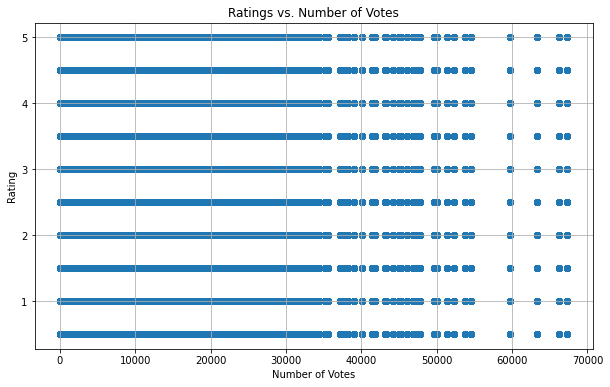

In [0]:
# Ratings vs. Number of Votes
# Join ratings and movie counts for scatter plot
movie_counts = ratings.groupBy("movieId").count().withColumnRenamed("count", "num_votes")
movie_ratings_with_counts = movie_ratings.join(movie_counts, on="movieId")

# Convert to Pandas for plotting
movie_ratings_with_counts_pd = movie_ratings_with_counts.select("rating", "num_votes").toPandas()

# Scatter plot: Ratings vs. Number of Votes
plt.figure(figsize=(10, 6))
plt.scatter(movie_ratings_with_counts_pd['num_votes'], movie_ratings_with_counts_pd['rating'], alpha=0.5)
plt.title('Ratings vs. Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Rating')
plt.grid(True)
plt.show()


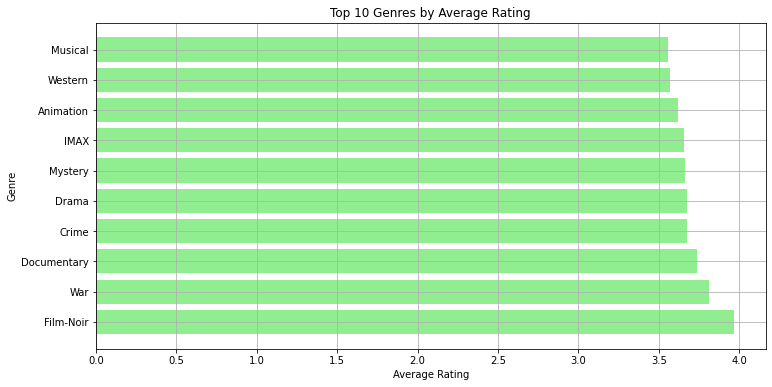

In [0]:
# Top 10 Genres by Average Rating
# Split movie genres and explode to get individual genre rows
from pyspark.sql.functions import explode, split

# Exploding genres into individual rows
movies_with_genres = movies.withColumn("genre", explode(split(movies['genres'], '\|')))

# Join movie ratings with genres and calculate the average rating per genre
genre_ratings = movie_ratings.join(movies_with_genres, on="movieId")
genre_avg_ratings = genre_ratings.groupBy("genre").avg("rating").orderBy("avg(rating)", ascending=False)

# Convert to Pandas for visualization
genre_avg_ratings_pd = genre_avg_ratings.limit(10).toPandas()

# Plotting the top 10 genres by average rating
plt.figure(figsize=(12, 6))
plt.barh(genre_avg_ratings_pd['genre'], genre_avg_ratings_pd['avg(rating)'], color='lightgreen')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Average Rating')
plt.grid(True)
plt.show()

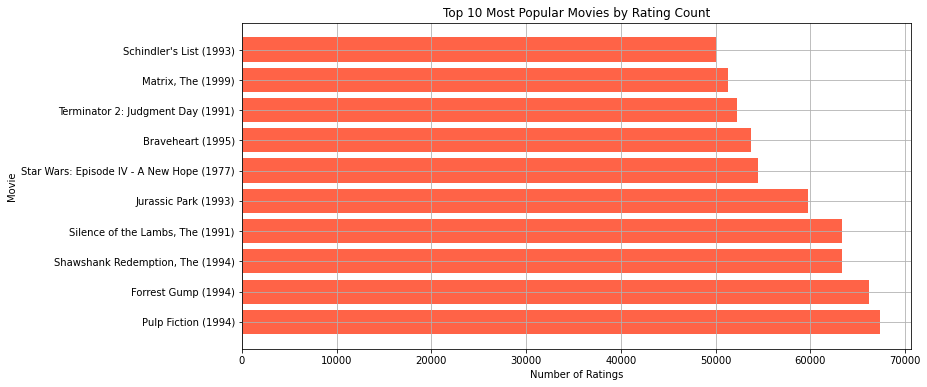

In [0]:
# Most Popular Movies by Rating Count
# Group by movieId to get the count of ratings per movie
movie_rating_counts = ratings.groupBy("movieId").count().withColumnRenamed("count", "rating_count")

# Join with movie titles for readability
popular_movies = movie_rating_counts.join(movies, on="movieId").orderBy("rating_count", ascending=False)

# Convert to Pandas for visualization
popular_movies_pd = popular_movies.limit(10).toPandas()

# Bar chart: Most Popular Movies by Rating Count
plt.figure(figsize=(12, 6))
plt.barh(popular_movies_pd['title'], popular_movies_pd['rating_count'], color='tomato')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie')
plt.title('Top 10 Most Popular Movies by Rating Count')
plt.grid(True)
plt.show()

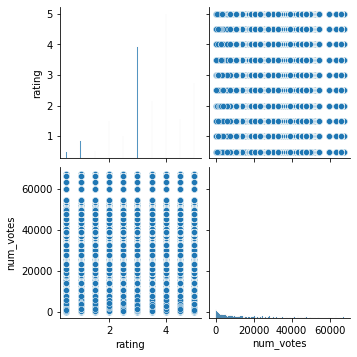

In [0]:
import seaborn as sns

# Pairplot for visualizing correlations 
sns.pairplot(movie_ratings_with_counts_pd)
plt.show()
